# RSSIと位相情報を可視化し精度確認


* 以下前提情報
    * Tag ID : E200 420D 49E0 6014 04E6 318A
    * 周波数 : 920.4MHz
    * タグの種類 : タイヤタグ
    * 送信電波出力 : 30.0dMb
    * タグ情報取得レート : 一秒ごとに一秒間取得
    * 各距離に対して、11回タグ情報を取得し、そのRSSIと位相の平均値を取得

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
from lmfit.models import SineModel
from scipy.optimize import curve_fit
%matplotlib inline

1. 読み取るタグ郡

In [69]:
TagTable = {
    'Tag1' : 'E200 420D 49E0 6014 04E6 318A'
}

2. 単位RSSI

In [70]:
RSSI0 = -58.5

2. CSVファイルを読み取り内容を出力

In [89]:
rfiddf=pd.read_csv('results.csv')
data_size = len(rfiddf)
rfiddf.head()

550


,Tag ID,RSSI,Phase,Frequency,Antenna No,Created At
0,E200 420D 49E0 6014 04E6 318A,-43.0,3.356350,920.4,7,2022/09/20 13:32:28
1,E200 420D 49E0 6014 04E6 318A,-43.0,3.368622,920.4,7,2022/09/20 13:32:30
2,E200 420D 49E0 6014 04E6 318A,-43.0,3.350214,920.4,7,2022/09/20 13:32:32
3,E200 420D 49E0 6014 04E6 318A,-43.0,3.350214,920.4,7,2022/09/20 13:32:34
4,E200 420D 49E0 6014 04E6 318A,-43.0,3.356350,920.4,7,2022/09/20 13:32:36


In [72]:
rfiddf.describe()

,RSSI,Phase,Frequency,Antenna No
count,550.000000,550.000000,5.500000e+02,550.0
mean,-45.584545,3.091189,9.204000e+02,7.0
std,4.863776,1.794641,2.275807e-13,0.0
min,-56.000000,0.110447,9.204000e+02,7.0
25%,-50.500000,1.583068,9.204000e+02,7.0
50%,-45.500000,2.896156,9.204000e+02,7.0
75%,-41.500000,4.810564,9.204000e+02,7.0
max,-38.000000,6.277049,9.204000e+02,7.0


In [73]:
rfiddf.loc[1]

Tag ID        E200 420D 49E0 6014 04E6 318A
RSSI                                  -43.0
Phase                              3.368622
Frequency                             920.4
Antenna No                                7
Created At              2022/09/20 13:32:30
Name: 1, dtype: object

3. 実際の距離に対する、RSSIと位相のDataFrameの作成

In [90]:
columns = ['Distance', 'RSSI', 'Phase']
data = np.empty((0,3))
for i in range(1, data_size):
    data = np.append(
        data,
        [[i, rfiddf['RSSI'][(i-1)*11:i*11].mean(), rfiddf['Phase'][(i-1)*11:i*11].mean()]],
        axis=0
    )
    i += 1
rfiddf_mean = pd.DataFrame(
    columns=columns,
    data=data
)
rfiddf_mean.head(10)

TypeError: 'float' object cannot be interpreted as an integer

4. データの整形
* 読み取りたいタグを指定。
* "Created At"はString型なので、datetime型に変更。
* 'Tag ID'と'date'のマルチインデックスを出力。

In [ ]:
rfiddf=rfiddf[rfiddf['Tag ID'] == TagTable['Tag1']]
rfiddf['date']=pd.to_datetime(rfiddf['Created At'])
rfiddf.set_index(['Tag ID','date']) # we get multi-index dataframe
rfiddf.head(10)

,Tag ID,RSSI,Phase,Frequency,Antenna No,Created At,date
0,E200 420D 49E0 6014 04E6 318A,-43.0,3.356350,920.4,7,2022/09/20 13:32:28,2022-09-20 13:32:28
1,E200 420D 49E0 6014 04E6 318A,-43.0,3.368622,920.4,7,2022/09/20 13:32:30,2022-09-20 13:32:30
2,E200 420D 49E0 6014 04E6 318A,-43.0,3.350214,920.4,7,2022/09/20 13:32:32,2022-09-20 13:32:32
3,E200 420D 49E0 6014 04E6 318A,-43.0,3.350214,920.4,7,2022/09/20 13:32:34,2022-09-20 13:32:34
4,E200 420D 49E0 6014 04E6 318A,-43.0,3.356350,920.4,7,2022/09/20 13:32:36,2022-09-20 13:32:36
5,E200 420D 49E0 6014 04E6 318A,-43.0,3.344078,920.4,7,2022/09/20 13:32:38,2022-09-20 13:32:38
6,E200 420D 49E0 6014 04E6 318A,-43.0,3.344078,920.4,7,2022/09/20 13:32:40,2022-09-20 13:32:40
7,E200 420D 49E0 6014 04E6 318A,-43.0,3.325670,920.4,7,2022/09/20 13:32:42,2022-09-20 13:32:42
8,E200 420D 49E0 6014 04E6 318A,-43.0,3.350214,920.4,7,2022/09/20 13:32:44,2022-09-20 13:32:44
9,E200 420D 49E0 6014 04E6 318A,-43.0,3.337942,920.4,7,2022/09/20 13:32:46,2022-09-20 13:32:46


5. 取得したデータのピボットテーブルを取得する。行は'date'、列は'Tag ID'。

In [ ]:
TA_Rssi_TS=rfiddf.pivot_table(index='date', columns=['Tag ID','Antenna No'], values=['RSSI', 'Phase'])
TA_Rssi_TS.head()

,Phase,RSSI
Tag ID,E200 420D 49E0 6014 04E6 318A,E200 420D 49E0 6014 04E6 318A
Antenna No,7,7
date,,
2022-09-20 13:32:28,3.356350,-43.0
2022-09-20 13:32:30,3.368622,-43.0
2022-09-20 13:32:32,3.350214,-43.0
2022-09-20 13:32:34,3.350214,-43.0
2022-09-20 13:32:36,3.356350,-43.0


6. 列から行へピボット

In [ ]:
A_Rssi_ATS=TA_Rssi_TS.stack(level=0)
A_Rssi_ATS.head()

Tag ID                    E200 420D 49E0 6014 04E6 318A
Antenna No                                            7
date                                                   
2022-09-20 13:32:28 Phase                      3.356350
                    RSSI                     -43.000000
2022-09-20 13:32:30 Phase                      3.368622
                    RSSI                     -43.000000
2022-09-20 13:32:32 Phase                      3.350214

In [ ]:
TA_Rssi_TS0 = A_Rssi_ATS.unstack()
TA_Rssi_TS0.head()

Tag ID              E200 420D 49E0 6014 04E6 318A      
Antenna No                                      7      
                                            Phase  RSSI
date                                                   
2022-09-20 13:32:28                      3.356350 -43.0
2022-09-20 13:32:30                      3.368622 -43.0
2022-09-20 13:32:32                      3.350214 -43.0
2022-09-20 13:32:34                      3.350214 -43.0
2022-09-20 13:32:36                      3.356350 -43.0

In [ ]:
TA_Rssi_TS0.index # check that the dataframe is TimeSeries

DatetimeIndex(['2022-09-20 13:32:28', '2022-09-20 13:32:30',
               '2022-09-20 13:32:32', '2022-09-20 13:32:34',
               '2022-09-20 13:32:36', '2022-09-20 13:32:38',
               '2022-09-20 13:32:40', '2022-09-20 13:32:42',
               '2022-09-20 13:32:44', '2022-09-20 13:32:46',
               ...
               '2022-09-20 15:41:45', '2022-09-20 15:41:47',
               '2022-09-20 15:41:49', '2022-09-20 15:41:51',
               '2022-09-20 15:41:53', '2022-09-20 15:41:55',
               '2022-09-20 15:41:57', '2022-09-20 15:41:59',
               '2022-09-20 15:42:01', '2022-09-20 15:42:03'],
              dtype='datetime64[ns]', name='date', length=550, freq=None)

7. 時間でソート

In [ ]:
TA_Rssi_TS0=TA_Rssi_TS0.sort_index()
TA_Rssi_TS0.head()

Tag ID              E200 420D 49E0 6014 04E6 318A      
Antenna No                                      7      
                                            Phase  RSSI
date                                                   
2022-09-20 13:32:28                      3.356350 -43.0
2022-09-20 13:32:30                      3.368622 -43.0
2022-09-20 13:32:32                      3.350214 -43.0
2022-09-20 13:32:34                      3.350214 -43.0
2022-09-20 13:32:36                      3.356350 -43.0

In [ ]:
TA_Rssi_TS0.index # check that the dataframe is TimeSeries

DatetimeIndex(['2022-09-20 13:32:28', '2022-09-20 13:32:30',
               '2022-09-20 13:32:32', '2022-09-20 13:32:34',
               '2022-09-20 13:32:36', '2022-09-20 13:32:38',
               '2022-09-20 13:32:40', '2022-09-20 13:32:42',
               '2022-09-20 13:32:44', '2022-09-20 13:32:46',
               ...
               '2022-09-20 15:41:45', '2022-09-20 15:41:47',
               '2022-09-20 15:41:49', '2022-09-20 15:41:51',
               '2022-09-20 15:41:53', '2022-09-20 15:41:55',
               '2022-09-20 15:41:57', '2022-09-20 15:41:59',
               '2022-09-20 15:42:01', '2022-09-20 15:42:03'],
              dtype='datetime64[ns]', name='date', length=550, freq=None)

8. 時間に対するRSSIと位相をそれぞれプロット
* 赤がRSSI、青が位相

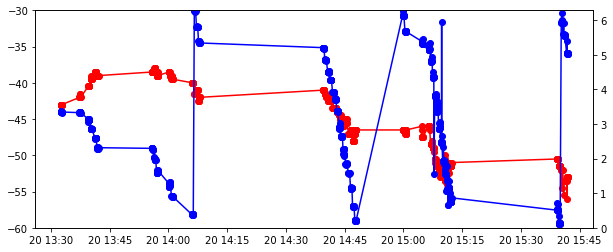

In [ ]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot()
ax2 = ax1.twinx()
ax1.set_ylim(-60,-30)
ax2.set_ylim(0,6.28)
ax1.plot(TA_Rssi_TS0[TagTable['Tag1'],'7']['RSSI'], color='red', label="RSSI", marker="o")
ax2.plot(TA_Rssi_TS0[TagTable['Tag1'],'7']['Phase'], color='blue', label="Phase", marker='o')

9. アンテナからの実際の距離に対する、RSSIと位相をそれぞれプロット
* 赤がRSSI、青が位相

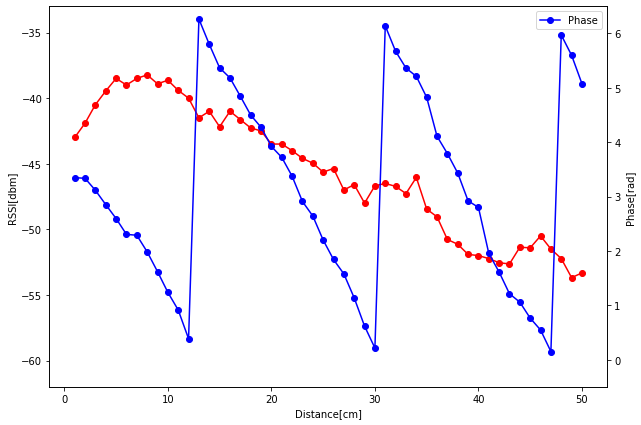

In [ ]:
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot()
ax2 = ax1.twinx()
ax1.set_xlabel('Distance[cm]')
ax1.set_ylim(-62,-33)
ax1.set_ylabel('RSSI[dbm]')
ax2.set_ylim(-0.5,6.5)
ax2.set_ylabel('Phase[rad]')
ax1.plot(rfiddf_mean['Distance'], rfiddf_mean['RSSI'], label="RSSI", color='red',  marker="o")
ax2.plot(rfiddf_mean['Distance'], rfiddf_mean['Phase'], label="Phase", color='blue',  marker='o')
plt.legend()
plt.show()

11. 単位RSSIを用いた、RSSIから距離への変換＋実際の距離に対する計測した距離をプロット

best-fit parameters = [0.93639203 2.47793578]
covariance = 
[[ 0.00274392 -0.06996998]
 [-0.06996998  2.35565615]]


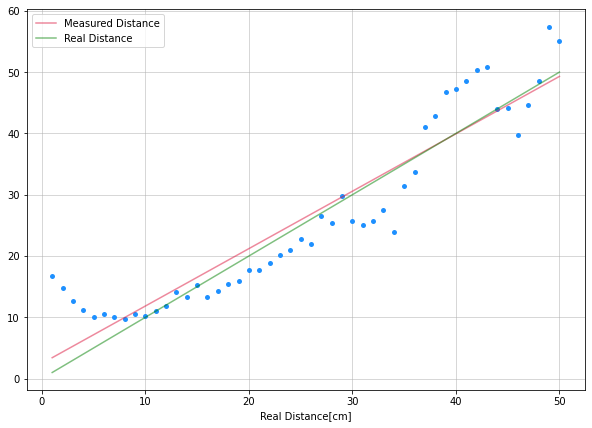

In [ ]:
distance_data = np.empty((0,2))
columns = ['Real_Distance', 'Measured_Distance']
for i in range(0, 50):
    mean = rfiddf_mean['RSSI'][i]
    distance_data = np.append(
        distance_data,
        [[i+1, pow(10, (RSSI0 - mean)/20) * 100]],
        axis=0
    )
distance = pd.DataFrame(
    data=distance_data,
    columns=columns,
    )

def fit_func(x, a, b):
    return a*x + b

x=distance['Real_Distance']
y=distance['Measured_Distance']

popt, pcov = curve_fit(fit_func, x, y, p0=(1, 0))
print(f"best-fit parameters = {popt}")
print(f"covariance = \n{pcov}")

fig, p = plt.subplots(1, 1, sharex=True, figsize=(10,7))

p.plot(x, y, "o", markersize=5, markerfacecolor="dodgerblue", markeredgewidth=0.0, fillstyle="full")
p.plot(x, fit_func(np.array(x), *popt), alpha=0.5, color="crimson", label='Measured Distance')
p.plot(x, x, alpha=0.5, color="green", label='Real Distance')
p.set_xlabel('Real Distance[cm]')
p.grid(linewidth=0.5)
p.legend()

12. 正解位相と計測した位相に関するデータフレームを作成

In [ ]:
Measured_Sin = pd.DataFrame(
    data={
        'Distance' : list(range(1, 51)),
        'phase' : rfiddf_mean['Phase'],
        'sin(phase)' : np.sin(rfiddf_mean['Phase']),
        'default_sin' : np.sin((4*np.pi*rfiddf_mean['Distance']/32.57)%(2*np.pi))
        }
)

13. 計測した位相をsin(phase)で可視化

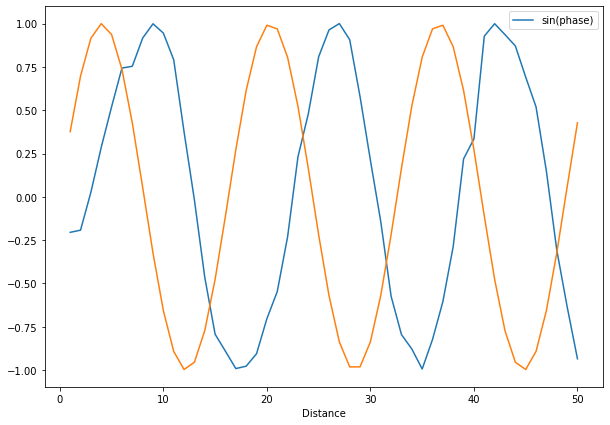

In [ ]:
ax = Measured_Sin.plot(x='Distance', y='sin(phase)', figsize=(10,7))
ax.plot(Measured_Sin['Distance'], Measured_Sin['default_sin'])
plt.legend()
plt.show()

14. sin(phase)のカーブフィッティング

best-fit parameters = [34.99133398  4.8624136 ]
covariance = 
[[0.06822835 0.01800423]
 [0.01800423 0.0063541 ]]


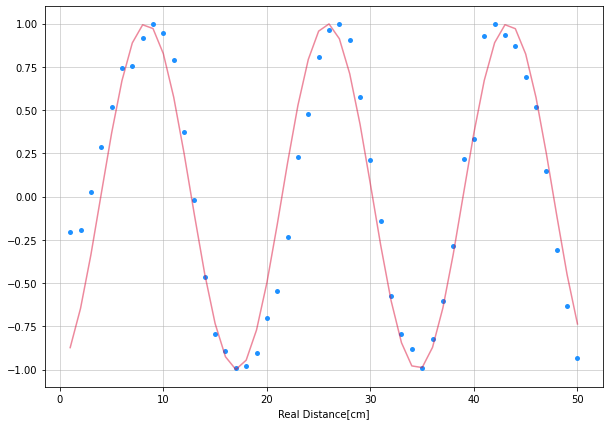

In [ ]:
def fit_func(x, a, b):
    return np.sin(((4 * np.pi * x) / a + b) % (2 * np.pi))

x=Measured_Sin['Distance']
y=Measured_Sin['sin(phase)']

popt, pcov = curve_fit(fit_func, x, y, p0=(32.57, 0))
popt[1]=(2*np.pi + popt[1]) % (2*np.pi)
print(f"best-fit parameters = {popt}")
print(f"covariance = \n{pcov}")

fig, p = plt.subplots(1, 1, sharex=True, figsize=(10,7))

p.plot(x, y, "o", markersize=5, markerfacecolor="dodgerblue", markeredgewidth=0.0, fillstyle="full")
p.plot(x, fit_func(np.array(x), *popt), alpha=0.5, color="crimson")
p.set_xlabel('Real Distance[cm]')
p.grid(linewidth=0.5)